In [1]:
import numpy as np
import pandas as pd

#optimize只能执行最小化
from scipy.optimize import minimize  

#Interactive Visualization
import plotly.graph_objects as go

# Set the display options
from typing import Optional #用于类型提示比如函数参数可以是float/None
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
# Define the Portfolio Optimization class with the Core-Satellite strategy

class PortfolioOptimization:
    def __init__(self, data: pd.DataFrame, risk_free_rate: float = 0.0, weight_bounds=(0.0, 1.0)):
        self.assets = data.columns  #保存资产名称（ETF代码）
        self.data = data
        self.returns = data.pct_change().dropna() #计算每日收益率
        self.expected_returns = self.returns.mean().dropna() * 252  #计算每只ETF的年化预期收益 (重要)
        self.cov_matrix = self.returns.cov().dropna() * 252 #计算收益率年化协方差矩阵表示资产之间风险的相关性 (重要)
        
        # Saving the basic Parameters and the number of assets
        self.risk_free_rate = risk_free_rate #存储无风险利率
        self.weight_bounds = weight_bounds #存储资产权重上下限
        self.number_of_assets = len(data.columns) #资产个数

    # Define the portfolio Variance 
    def _portfolio_variance(self, weights: np.ndarray) -> float:
        return weights.T @ self.cov_matrix.values @ weights     

    # Define the portfolio Return      
    def _portfolio_return(self, weights: np.ndarray) -> float:
        return np.sum(weights * self.expected_returns.values)   


    # Define the portfolio's Sharpe Ratio (优化目标)
    def _negative_sharpe_ratio(self, weights: np.ndarray) -> float:
        ret = self._portfolio_return(weights)   # 计算这个组合的年化预期收益
        std = np.sqrt(self._portfolio_variance(weights)) # 得到组合的年化标准差
        return -(ret - self.risk_free_rate) / std if std != 0 else np.inf    
                                                                           
    # 设计 CPI + 6% 的目标校验 
    def evaluate_target_return(self, portfolio: dict, cpi: float = 0.03) -> str:
        target = cpi + 0.06
        actual = portfolio["expected_return"]
    
        if actual >= target:
            result = f"Portfolio meets the target return of {target:.2%} (Actual: {actual:.2%})"
        else:
            result = f"Portfolio does NOT meet the target return of {target:.2%} (Actual: {actual:.2%})"
        return result
    
# 定义有核心-卫星策略下的最优投资组合 (核心逻辑)
    def optimize_with_core_satellite(
        self,
        core_etfs: list,
        satellite_etfs: list,
        target_return: float = None, #如果有明确收益目标可以强制添加为优化约束
        maximize_sharpe: bool = True #是否以最大化Sharpe为目标。如果为False则切换成最小方差模型。
    ):
        n_assets = len(self.assets)                       #初始化资产数量
        initial_weights = np.ones(n_assets) / n_assets    #设置初始权重为平均分配，每个资产 = 1/N

        bounds = []
        core_list = []
        satellite_list = []
        
        for asset in self.assets:
            if asset in core_etfs:
                bounds.append((0.10, 0.50))  # each core: 10%-50%
                core_list.append(1)
                satellite_list.append(0)
            elif asset in satellite_etfs:
                bounds.append((0.01, 0.10))   # each satellite: 1%-10%
                core_list.append(0)
                satellite_list.append(1)
            else:
                raise ValueError(f"The asset {asset} is not found in core or satellite list")
        
        #定义约束
        constraints = [
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},  #类型是等式约束,函数要求所有权重加总必须等于1
            {"type": "ineq", "fun": lambda w: np.dot(w, core_list) - 0.65},  # core >= 65%
            {"type": "ineq", "fun": lambda w: 0.85 - np.dot(w, core_list)},  # core <= 85%
            {"type": "ineq", "fun": lambda w: np.dot(w, satellite_list) - 0.15},  # satellite >= 15%
            {"type": "ineq", "fun": lambda w: 0.35 - np.dot(w, satellite_list)},  # satellite <= 35%
        ]
        
        #如果指定了具体年化收益目标，就强制组合收益要刚好等于它
        if target_return is not None:
            constraints.append({
                "type": "eq",
                "fun": lambda w: self._portfolio_return(w) - target_return
            })
        
        #使用优化器最小化 Neg Sharpe or最小化方差
        result = minimize(
            self._negative_sharpe_ratio if maximize_sharpe else self._portfolio_variance,
            initial_weights,
            method = "SLSQP", #支持不等式和等式约束
            bounds = bounds,
            constraints = constraints
        )
        #提取最优解，每个资产对应的最优权重向量
        weights = result.x  
        
        #构建结果字典并返回
        return {
            "weights": dict(zip(self.assets, weights)),
            "expected_return": self._portfolio_return(weights),
            "expected_risk": np.sqrt(self._portfolio_variance(weights)),
            "sharpe_ratio": -(result.fun) if maximize_sharpe else (        #是在这个最优解下目标函数的具体值
                (self._portfolio_return(weights) - self.risk_free_rate) /
                np.sqrt(self._portfolio_variance(weights))
            )
        }
   
# 定义蒙特卡洛模拟(核心逻辑) 
    
    def monte_carlo_simulation(self, number_of_portfolio: int = 5000): #随机生成5,000个不同权重组合
        results = []
        for _ in range(number_of_portfolio): 
            weights = np.random.dirichlet(np.ones(self.number_of_assets), size=1).flatten() #来生成一组加起来为1的非负数，作为资产权重, one()是说每个资产都给同样的权重倾向均匀分布， 最后把二维数组变成一维向量。

            portfolio_return = self._portfolio_return(weights) #计算该组合的年化收益
            portfolio_risk = np.sqrt(self._portfolio_variance(weights)) #计算组合的年化风险
            sharpe_ratio = (                                            #计算夏普比率
                (portfolio_return - self.risk_free_rate) / portfolio_risk
                if portfolio_risk != 0
                else None
            )

           #把当前组合的信息打包成一个字典添加到 results 列表中
            results.append(
                {
                    "weights": dict(zip(self.assets, weights)), #zip函数把每个资产名和它的权重配对
                    "expected_return": portfolio_return,
                    "expected_risk": portfolio_risk,
                    "sharpe_ratio": sharpe_ratio,
                }
            )
        return pd.DataFrame(results)

    
    # 定义一般的投资组合优化函数 (核心逻辑)
    def optimize_portfolio(                   
        self,
        target_return: Optional[float] = None,  #明确收益目标 找最小波动
        target_risk: Optional[float] = None,    #明确波动率、找最大收益
        maximize_sharpe: bool = False,          #找最大 Sharpe比率
    ):
        if target_risk is not None and target_return is not None:     #报错提醒 如果同时指定了收益和风险模型可能无解
            raise ValueError("Specify either target_return or target_risk, it can not be both.")
        
        initial_weights = np.ones(self.number_of_assets) / self.number_of_assets     #初始化权重为等权配置

        bounds = self.weight_bounds
        constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]    #权重总和必须等于 1
        
        #如果选了最大化 Sharpe 比率，就把“负的 Sharpe”当作目标函数
        if maximize_sharpe:
            objective = self._negative_sharpe_ratio     
        #如果指定了目标波动率，在固定风险水平下去最大化 Sharpe
        elif target_risk is not None:                   
            objective = self._negative_sharpe_ratio
            constraints.append(
                {"type": "eq",
                 "fun": lambda x: target_risk**2 - self._portfolio_variance(x),
                })
        else:        
            #如果指定了目标收益率 就加个约束:组合收益 = 目标收益
            if target_return is not None:
                constraints.append(
                    {"type": "eq",
                     "fun": lambda x: target_return - self._portfolio_return(x),
                    })
            #如果都没指定默认目标函数是最小化组合波动率
            objective = self._portfolio_variance
       
        # 执行优化器
        result = minimize(
            objective,
            initial_weights,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )
        # 计算最优权重下的组合预期收益和组合标准差
        portfolio_return = self._portfolio_return(result.x)
        portfolio_risk = np.sqrt(self._portfolio_variance(result.x))
        
        # 计算Sharpe比率
        sharpe_ratio = (
            (portfolio_return - self.risk_free_rate) / portfolio_risk
            if portfolio_risk != 0
            else 0
        )
        
        # 将结果打包为字典
        return {
            "weights": dict(zip(self.assets, result.x)),
            "expected_return": portfolio_return,
            "expected_risk": portfolio_risk,
            "sharpe_ratio": sharpe_ratio,
        }
    # 定义组合结果输出的函数(展示：组合权重，预期收益、风险、和Sharp比率) 
    def print_portfolio(self, portfolio: dict):
        print("Weights:")
        for asset, weight in portfolio["weights"].items():
            print(f"  {asset}: {weight:.4f}")
        
        print(f"Expected Return: {portfolio['expected_return']:.4f}")
        print(f"Expected Risk: {portfolio['expected_risk']:.4f}")
        print(f"Sharpe Ratio: {portfolio['sharpe_ratio']:.4f}")
    
    #组合的 Monte Carlo模拟可视化
    def plot_simulation(self, temp: pd.DataFrame):
        
        # 使用散点图展示所有组合
        fig = go.Figure(
            data=go.Scatter(
                x=temp["expected_risk"],
                y=temp["expected_return"],
                mode="markers",
                marker=dict(
                    color=temp["sharpe_ratio"],
                    colorbar=dict(
                        title="Sharpe Ratio",
                        tickvals=[temp["sharpe_ratio"].min(), temp["sharpe_ratio"].max()],
                        ticktext=[f"{temp['sharpe_ratio'].min():.2f}", f"{temp['sharpe_ratio'].max():.2f}"],
                    ),
                    symbol="cross",
                ),
                name="Simulated Portfolio",
                text=temp["sharpe_ratio"],
                hovertemplate="Sharpe Ratio: %{text}<br>Expected Volatility: %{x}<br>Expected Return: %{y}<extra></extra>",
                showlegend=True,
            )
        )

        # 标记出Sharpe比率最高的组合
        max_sharpe_idx = temp.sharpe_ratio.idxmax()
        fig.add_trace(
            go.Scatter(
                x=[temp.iloc[max_sharpe_idx]["expected_risk"]],
                y=[temp.iloc[max_sharpe_idx]["expected_return"]],
                mode="markers",
                marker=dict(color="RoyalBlue", size=20, symbol="star"),
                name="Max Sharpe",
                text="Max Sharpe Portfolio",
                hovertemplate="Max Sharpe Portfolio<br>Expected Volatility: %{x}<br>Expected Return: %{y}<extra></extra>",
            )
        )
     
        fig.update_layout(
            title="Monte Carlo Simulated Portfolio",
            xaxis_title="Expected Volatility",
            yaxis_title="Expected Return",
            width=800,
            height=600,
            showlegend=False,
        )
        fig.update_xaxes(showspikes=True)
        fig.update_yaxes(showspikes=True)
        fig.show()
    
    # 定义有效前沿画图
    def plot_efficient_frontier(self, temp: pd.DataFrame, highlight_portfolio: dict = None, title: str = "Efficient Frontier"):
        fig = go.Figure()
    
        # 绘制所有模拟组合
        fig.add_trace(go.Scatter(
            x=temp['expected_risk'],
            y=temp['expected_return'],
            mode='markers',
            marker=dict(
                color=temp['sharpe_ratio'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title='Sharpe Ratio')
            ),
            name='Simulated Portfolios',
            text=[f"Sharpe: {x:.2f}" for x in temp['sharpe_ratio']],
            hovertemplate='Risk: %{x:.2%}<br>Return: %{y:.2%}<br>%{text}<extra></extra>'
        ))

       
        if highlight_portfolio:
            fig.add_trace(go.Scatter(
                x=[highlight_portfolio['expected_risk']],
                y=[highlight_portfolio['expected_return']],
                mode='markers+text',
                marker=dict(color='red', size=14, symbol='star'),
                text=['Core Satellite Portfolio'],
                textposition='top center',
                name='Highlighted Portfolio',
                hovertemplate='Portfolio<br>Risk: %{x:.2%}<br>Return: %{y:.2%}<extra></extra>'
            ))
    
        
        fig.update_layout(
            title=title,
            xaxis_title='Expected Volatility (Risk)',
            yaxis_title='Expected Return',
            width=800,
            height=600,
            showlegend=True
        )
    
        fig.show()


In [3]:
# 输入投资组合的各ETF数据

aaa = pd.read_csv("aaa.csv", encoding="utf-8-sig")
aaa.columns = aaa.columns.str.strip() 
aaa = aaa[["Date", "NAV"]]  
aaa["Date"] = pd.to_datetime(aaa["Date"])
aaa.set_index("Date", inplace=True)
aaa.rename(columns={"NAV": "AAA"}, inplace=True)

asia = pd.read_csv("asia.csv", encoding="utf-8-sig")
asia.columns = asia.columns.str.strip()  
asia = asia[["Date", "NAV"]]  
asia["Date"] = pd.to_datetime(asia["Date"])
asia.set_index("Date", inplace=True)
asia.rename(columns={"NAV": "ASIA"}, inplace=True)

bnds = pd.read_csv("bnds.csv", encoding="utf-8-sig")
bnds.columns = bnds.columns.str.strip()  
bnds = bnds[["Date", "NAV"]]  
bnds["Date"] = pd.to_datetime(bnds["Date"])
bnds.set_index("Date", inplace=True)
bnds.rename(columns={"NAV": "BNDS"}, inplace=True)

smll = pd.read_csv("smll.csv", encoding="utf-8-sig")
smll.columns = smll.columns.str.strip()  
smll = smll[["Date", "NAV"]]  
smll["Date"] = pd.to_datetime(smll["Date"])
smll.set_index("Date", inplace=True)
smll.rename(columns={"NAV": "SMLL"}, inplace=True)

xmet = pd.read_csv("xmet.csv", encoding="utf-8-sig")
xmet.columns = xmet.columns.str.strip()  
xmet = xmet[["Date", "NAV"]]  
xmet["Date"] = pd.to_datetime(xmet["Date"])
xmet.set_index("Date", inplace=True)
xmet.rename(columns={"NAV": "XMET"}, inplace=True)

gcap = pd.read_csv("gcap.csv", encoding="utf-8-sig")
gcap.columns = gcap.columns.str.strip()  
gcap= gcap[["Date", "NAV"]] 
gcap["Date"] = pd.to_datetime(gcap["Date"], dayfirst=True)
gcap.set_index("Date", inplace=True)
gcap.rename(columns={"NAV": "GCAP"}, inplace=True)

emkt = pd.read_csv("emkt.csv", encoding="utf-8-sig")
emkt.columns = emkt.columns.str.strip()  
emkt = emkt[["Date", "NAV"]]  
emkt["Date"] = pd.to_datetime(emkt["Date"], dayfirst=True)
emkt.set_index("Date", inplace=True)
emkt.rename(columns={"NAV": "EMKT"}, inplace=True)

ebnd = pd.read_csv("ebnd.csv", encoding="utf-8-sig")
ebnd.columns = ebnd.columns.str.strip()  
ebnd = ebnd[["Date", "NAV"]]  
ebnd["Date"] = pd.to_datetime(ebnd["Date"], dayfirst=True)
ebnd.set_index("Date", inplace=True)
ebnd.rename(columns={"NAV": "EBND"}, inplace=True)

iwld = pd.read_csv("iwld.csv", encoding="utf-8-sig")
iwld.columns = iwld.columns.str.strip()  
iwld = iwld[["Date", "NAV"]]  
iwld["Date"] = pd.to_datetime(iwld["Date"], dayfirst=True)
iwld.set_index("Date", inplace=True)
iwld.rename(columns={"NAV": "IWLD"}, inplace=True)

price_data = pd.concat([aaa, asia, bnds, smll, xmet, gcap, emkt, ebnd, iwld], axis=1).dropna()
price_data.index = pd.to_datetime(price_data.index)

# 筛选日期范围
filtered_data = price_data.loc["2023-10-31" : "2024-04-30"]
filtered_data

# 定义core和satellite ETF
core_etfs = ["AAA", "ASIA", "IWLD", "EBND"]
satellite_etfs = ["SMLL", "XMET", "GCAP", "EMKT", "BNDS"]
all_etfs = core_etfs + satellite_etfs

# 设置每个 ETF 的权重限制
weight_bounds = []
for etf in all_etfs:
    if etf in core_etfs:
        weight_bounds.append((0.1, 0.5))
    else:
        weight_bounds.append((0.00001, 0.1))  # 大于 0%，不等于 0


In [4]:
optimizer = PortfolioOptimization(data=filtered_data, weight_bounds=weight_bounds)

# 执行优化（最大化夏普比率）
result = optimizer.optimize_with_core_satellite(
    core_etfs=core_etfs,
    satellite_etfs=satellite_etfs,
    maximize_sharpe=True
)

/Users/nickshang/anaconda3/envs/Quant_Learning/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/nickshang/anaconda3/envs/Quant_Learning/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/nickshang/anaconda3/envs/Quant_Learning/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/Users/nickshang/anaconda3/envs/Quant_Learning/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


In [5]:
optimizer.print_portfolio(result)
optimizer.evaluate_target_return(result, cpi=0.0315)

Weights:
  AAA: 0.1000
  ASIA: 0.1000
  BNDS: 0.0122
  SMLL: 0.0100
  XMET: 0.0580
  GCAP: 0.1000
  EMKT: 0.1000
  EBND: 0.1655
  IWLD: 0.3544
Expected Return: 0.2518
Expected Risk: 0.0455
Sharpe Ratio: 5.5390


'Portfolio meets the target return of 9.15% (Actual: 25.18%)'

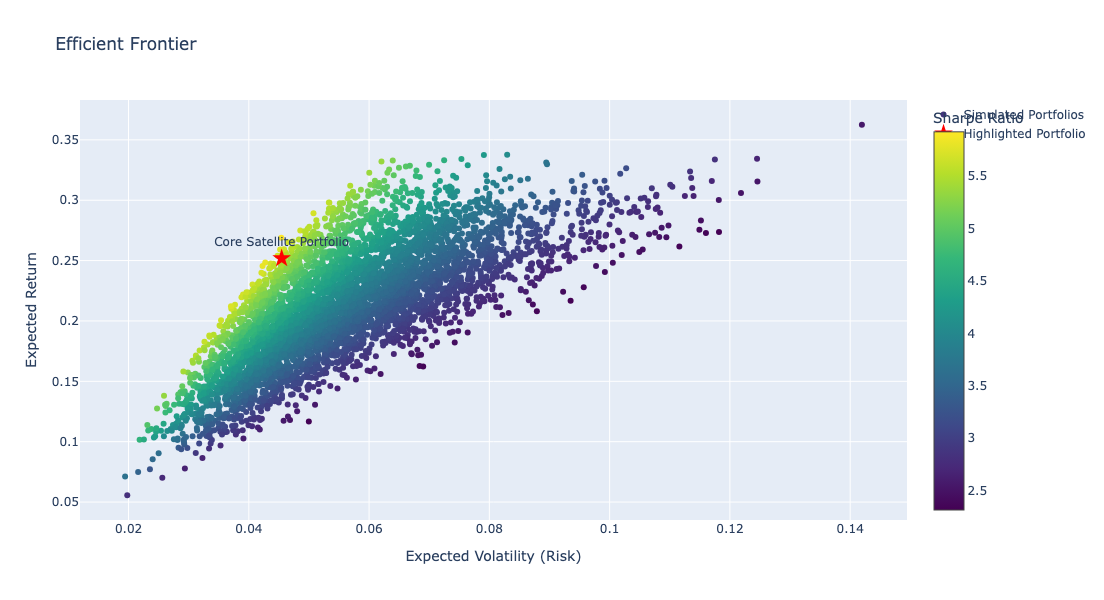

In [6]:
sim = optimizer.monte_carlo_simulation()
optimizer.plot_efficient_frontier(sim, highlight_portfolio=result)